# Outline of the metabolomics data analysis

In this notebook we briefly go through the steps taken to perform the analysis on the metabolomics dataset in the paper.

#### Requirements

We recommend creating a fresh python environment and installing the required libraries via
```
pip install -r requirements.txt
```

### 0. Imports

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import pandas as pd

from tensorly.decomposition import non_negative_parafac

import matcouply
from matcouply.decomposition import cmf_aoadmm, initialize_cmf
from matcouply.penalties import Parafac2,NonNegativity

from copy import deepcopy
import plot_funcs

### 1. Load the data and preprocessing

In [2]:
# Load the data
data_object = sio.loadmat("Z_males.mat", simplify_cells=True)["Z"]

K = len(data_object["object"])

data = np.empty(
    (data_object["object"][0].shape[0], data_object["object"][0].shape[1], K)
)

mask = np.empty_like(data)

for k in range(K):
    data[:, :, k] = data_object["object"][k]
    mask[:, :, k] = data_object["miss"][k]

In [ ]:
# Preprocessing

# Remove outliers (if applicable)

# Scale data (if applicable)

def preprocess_centerscale(X, flag_scale=True, flag_center=True):
    """
    Preprocess a 3D array (subjects × time × metabolites):
    - Center across subjects (mode-1)
    - Scale within each metabolite (mode-3) using RMS
    - Handles NaNs

    Parameters:
    - X: np.ndarray, shape (subjects, time, metabolites)
    - flag_scale: bool, whether to apply RMS scaling
    - flag_center: bool, whether to apply centering

    Returns:
    - Xpre: np.ndarray, preprocessed version of X
    """
    Xpre = np.copy(X)

    if flag_center:
        mean_subjects = np.nanmean(Xpre, axis=0)
        for i in range(Xpre.shape[0]):
            Xpre[i, :, :] = Xpre[i, :, :] - mean_subjects

    if flag_scale:
        for k in range(Xpre.shape[2]):
            rms = np.sqrt(np.nanmean(Xpre[:, :, k] ** 2))
            if rms != 0:
                Xpre[:, :, k] /= rms
            else:
                Xpre[:, :, k] = 0

    return Xpre

# data = preprocess_centerscale(data, flag_scale=True, flag_center=False)

# Normalize data

# data = data / tl.norm(data)

In [3]:
# Missing data

# Here imputing with the mean across subjects are a spcific time-point.
# This will be later updated while fitting with EM.

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(K):
            if mask[i,j,k] == 0:
                data[i,j,k] = np.nan

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(K):
            if mask[i,j,k] == 0:
                data[i,j,k] = np.nanmean(data[i,j,:])

### 2. Reproducibility and replicability analysis

In [ ]:
# Check uniqueness

# CMF

# %run uniqueness_check.py cmf 2 0 -m males
# %run uniqueness_check.py cmf 3 0 -m males
# %run uniqueness_check.py cmf 4 0 -m males
# %run uniqueness_check.py cmf 5 0 -m males
# %run uniqueness_check.py cmf 6 0 -m males
# %run uniqueness_check.py cmf 7 0 -m males
# %run uniqueness_check.py cmf 8 0 -m males

# PARAFAC2

# %run uniqueness_check.py parafac2 2 0 -m males
# %run uniqueness_check.py parafac2 3 0 -m males
# %run uniqueness_check.py parafac2 4 0 -m males
# %run uniqueness_check.py parafac2 5 0 -m males
# %run uniqueness_check.py parafac2 6 0 -m males
# %run uniqueness_check.py parafac2 7 0 -m males
# %run uniqueness_check.py parafac2 8 0 -m males

# CP

# %run uniqueness_check.py cp 2 0 -m males
# %run uniqueness_check.py cp 3 0 -m males
# %run uniqueness_check.py cp 4 0 -m males
# %run uniqueness_check.py cp 5 0 -m males
# %run uniqueness_check.py cp 6 0 -m males
# %run uniqueness_check.py cp 7 0 -m males
# %run uniqueness_check.py cp 8 0 -m males

In [ ]:
# Check replicability

# CMF

# %run replicability_check.py cmf 2 0 -m males
# %run replicability_check.py cmf 3 0 -m males
# %run replicability_check.py cmf 4 0 -m males
# %run replicability_check.py cmf 5 0 -m males
# %run replicability_check.py cmf 6 0 -m males
# %run replicability_check.py cmf 7 0 -m males
# %run replicability_check.py cmf 8 0 -m males

# PARAFAC2

# %run replicability_check.py parafac2 2 0 -m males
# %run replicability_check.py parafac2 3 0 -m males
# %run replicability_check.py parafac2 4 0 -m males
# %run replicability_check.py parafac2 5 0 -m males
# %run replicability_check.py parafac2 6 0 -m males
# %run replicability_check.py parafac2 7 0 -m males
# %run replicability_check.py parafac2 8 0 -m males

# CP

# %run replicability_check.py cp 2 0 -m males
# %run replicability_check.py cp 3 0 -m males
# %run replicability_check.py cp 4 0 -m males
# %run replicability_check.py cp 5 0 -m males
# %run replicability_check.py cp 6 0 -m males
# %run replicability_check.py cp 7 0 -m males
# %run replicability_check.py cp 8 0 -m males

The output of these scripts is located at `Metabolomics/results/uniqueness/` and `Metabolomics/results/replicability/`, respectively. The results can be nicely summarized in a plot by `uniqueness_analysis_metabolomics.ipynb` and `replicability_analysis_metabolomics.ipynb`. To reproduce the exact plot of the paper `paper_plots.ipynb` can be used.

### 3. Model fitting

In [ ]:
# Fitting CP models

# ⚠️ This might take significant amount of time (> 1hr).

best_cp_error = np.inf
best_cp_factors = None

for init in tqdm.tqdm(range(40)):

    factors, errors = non_negative_parafac(
        tensor=data.T,
        tol=1e-8,
        rank=6,
        return_errors=True,
        n_iter_max=15000,
        mask=mask.T,
    )

    if len(errors) < 14990: # If we have not reached max number of iters
        if errors[-1] < best_cp_error: # did we get a better loss?
            best_cp_error = errors[-1]
            best_cp_factors = factors[1]

In [ ]:
# Fitting PARAFAC2

# ⚠️ This might take significant amount of time (> 1hr).

best_parafac2_error = np.inf
best_parafac2_factors = None

for init in range(40):

    (weights, (D, B, A)), run_diagnostics = cmf_aoadmm(
        matrices=data.T, # This needs to be transposed due to ordering of factors in matcouply
        rank=6,
        return_errors=True,
        n_iter_max=15000,
        regs=[
            [NonNegativity()],
            [NonNegativity(), Parafac2()],
            [NonNegativity()],
        ],
        tol=1e-8,
        inner_n_iter_max=20,
        absolute_tol=1e-6,
        feasibility_tol=1e-5,
        inner_tol=1e-5,
        mask=mask.T,
        verbose=500,
    )

    if (
        len(run_diagnostics.regularized_loss) > 14990
    ):
        continue
    else:
        if run_diagnostics.regularized_loss[-1] < best_parafac2_error:
            best_parafac2_error = run_diagnostics.regularized_loss[-1]
            best_parafac2_factors = (D, B, A)

In [ ]:
# Fitting CMF models

# ⚠️ This might take significant amount of time (> 1hr).

best_cmf_error = np.inf
best_cmf_factors = None

for init in range(40):

    weights, (A_init, B_init, D_init) = initialize_cmf(
        matrices=data.T,
        rank=6,
        init="random",
        svd_fun="truncated_svd",
    )

    A_init = np.ones_like(A_init)
    cmf_init = weights, (A_init, B_init, D_init)

    (weights, (D, B, A)), run_diagnostics = cmf_aoadmm(
        matrices=data.T, # This needs to be transposed due to ordering of factors in matcouply
        rank=6,
        return_errors=True,
        n_iter_max=8000,
        regs=[[NonNegativity()], [NonNegativity()], [NonNegativity()]],
        tol=1e-8,
        init=cmf_init,
        update_A=False,
        inner_n_iter_max=20,
        absolute_tol=1e-6,
        feasibility_tol=1e-5,
        inner_tol=1e-5,
        mask=mask.T,
        verbose=500,
    )

    if (
        len(run_diagnostics.regularized_loss) > 7990
    ):
        continue
    else:
        if run_diagnostics.regularized_loss[-1] < best_cmf_error:
            best_cmf_error = run_diagnostics.regularized_loss[-1]
            best_cmf_factors = (D, B, A)

### 4. Plot results

In [9]:
# Load metadata

# ⚠️ Load these for males
df = pd.read_csv("Metabolomics/meta_males_safe.csv")
group = df['group'].astype("string").to_numpy()  

metabolites = ['Total-C', 'Remnant-C', 'VLDL-C', 'LDL-C', 'HDL-C', 'Total-TG', 'VLDL-TG', 'LDL-TG', 'HDL-TG', 'Total-PL', 'VLDL-PL', 'LDL-PL', 'HDL-PL', 'Total-CE', 'VLDL-CE', 'LDL-CE', 'HDL-CE', 'Total-FC', 'VLDL-FC', 'LDL-FC', 'HDL-FC', 'Total-L', 'VLDL-L', 'LDL-L', 'HDL-L', 'Total-P', 'VLDL-P', 'LDL-P', 'HDL-P', 'VLDL size', 'LDL size', 'HDL size', 'ApoB', 'ApoA1', 'Total-FA', 'Unsaturation', 'Omega-3', 'Omega-6', 'PUFA', 'MUFA', 'SFA', 'LA', 'DHA', 'Ala', 'Gln', 'Gly', 'His', 'Total BCAA', 'Ile', 'Leu', 'Val', 'Tyr', 'Glucose', 'Lactate', 'Pyruvate', 'Citrate', 'bOHbutyrate', 'Acetate', 'Acetoacetate', 'Acetone', 'GlycA', 'XXL-VLDL-P', 'XXL-VLDL-L', 'XXL-VLDL-PL', 'XXL-VLDL-C', 'XXL-VLDL-CE', 'XXL-VLDL-FC', 'XXL-VLDL-TG', 'XL-VLDL-P', 'XL-VLDL-L', 'XL-VLDL-PL', 'XL-VLDL-C', 'XL-VLDL-CE', 'XL-VLDL-FC', 'XL-VLDL-TG', 'L-VLDL-P', 'L-VLDL-L', 'L-VLDL-PL', 'L-VLDL-C', 'L-VLDL-CE', 'L-VLDL-FC', 'L-VLDL-TG', 'M-VLDL-P', 'M-VLDL-L', 'M-VLDL-PL', 'M-VLDL-C', 'M-VLDL-CE', 'M-VLDL-FC', 'M-VLDL-TG', 'S-VLDL-P', 'S-VLDL-L', 'S-VLDL-PL', 'S-VLDL-C', 'S-VLDL-CE', 'S-VLDL-FC', 'S-VLDL-TG', 'XS-VLDL-P', 'XS-VLDL-L', 'XS-VLDL-PL', 'XS-VLDL-C', 'XS-VLDL-CE', 'XS-VLDL-FC', 'XS-VLDL-TG', 'IDL-P', 'IDL-L', 'IDL-PL', 'IDL-C', 'IDL-CE', 'IDL-FC', 'IDL-TG', 'L-LDL-P', 'L-LDL-L', 'L-LDL-PL', 'L-LDL-C', 'L-LDL-CE', 'L-LDL-FC', 'L-LDL-TG', 'M-LDL-P', 'M-LDL-L', 'M-LDL-PL', 'M-LDL-C', 'M-LDL-CE', 'M-LDL-FC', 'M-LDL-TG', 'S-LDL-P', 'S-LDL-L', 'S-LDL-PL', 'S-LDL-C', 'S-LDL-CE', 'S-LDL-FC', 'S-LDL-TG', 'XL-HDL-P', 'XL-HDL-L', 'XL-HDL-PL', 'XL-HDL-C', 'XL-HDL-CE', 'XL-HDL-FC', 'XL-HDL-TG', 'L-HDL-P', 'L-HDL-L', 'L-HDL-PL', 'L-HDL-C', 'L-HDL-CE', 'L-HDL-FC', 'L-HDL-TG', 'M-HDL-P', 'M-HDL-L', 'M-HDL-PL', 'M-HDL-C', 'M-HDL-CE', 'M-HDL-FC', 'M-HDL-TG', 'S-HDL-P', 'S-HDL-L', 'S-HDL-PL', 'S-HDL-C', 'S-HDL-CE', 'S-HDL-FC', 'S-HDL-TG', 'Insulin', 'Cpeptid']
metabolite_class = ['Cholesterol', 'Cholesterol', 'Cholesterol', 'Cholesterol', 'Cholesterol', 'Triglycerides', 'Triglycerides', 'Triglycerides', 'Triglycerides', 'Phospholipids', 'Phospholipids', 'Phospholipids', 'Phospholipids', 'Cholesteryl esters', 'Cholesteryl esters', 'Cholesteryl esters', 'Cholesteryl esters', 'Free cholesterol', 'Free cholesterol', 'Free cholesterol', 'Free cholesterol', 'Total lipids', 'Total lipids', 'Total lipids', 'Total lipids', 'Lipoprotein particle concentrations', 'Lipoprotein particle concentrations', 'Lipoprotein particle concentrations', 'Lipoprotein particle concentrations', 'Lipoprotein particle sizes', 'Lipoprotein particle sizes', 'Lipoprotein particle sizes', 'Apolipoproteins', 'Apolipoproteins', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Fatty acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Amino acids', 'Glycolysis related metabolites', 'Glycolysis related metabolites', 'Glycolysis related metabolites', 'Glycolysis related metabolites', 'Ketone bodies', 'Ketone bodies', 'Ketone bodies', 'Ketone bodies', 'Inflammation', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', 'Lipoprotein subclasses', '', '']

# find indices where metabolite_class is 'Ketone bodies'
ketone_indices = [i for i, x in enumerate(metabolite_class) if x == 'Ketone bodies']
ketone_metabolites = [metabolites[i] for i in ketone_indices]

glycolisis = [i for i, x in enumerate(metabolite_class) if x == 'Glycolysis related metabolites']
glycolisis_metabolites = [metabolites[i] for i in glycolisis]

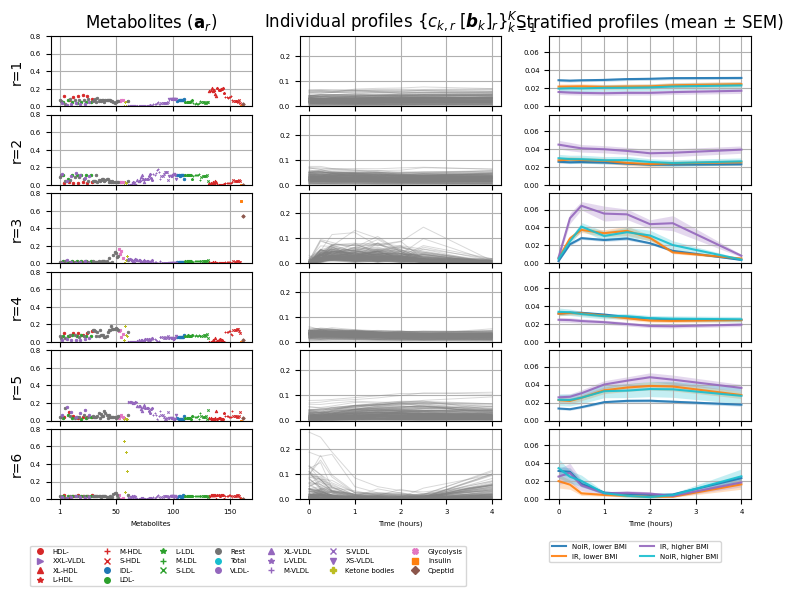

In [ ]:
model = 'parafac2' # can be 'cmf', 'cp' or 'parafac2'
n_components = 6

######################################################

if model == 'cp':
    best_factors = best_cp_factors
    A = best_factors[2]
    C = best_factors[0]
    B = [deepcopy(best_factors[1]) for _ in range(A.shape[0])]
else:
    if model == 'parafac2':
        best_factors = best_parafac2_factors
        B = best_factors[1]
        A = best_factors[2]
        C = best_factors[0]
    elif model == 'cmf':
        best_factors = best_cmf_factors
        B = best_factors[1]
        A = best_factors[2]
        C = best_factors[0]

fig, axs = plt.subplots(
    n_components, 3,
    figsize=(8,0.65 * 8),
    constrained_layout=False
)

fig.subplots_adjust(
    left=0.06, right=0.935, bottom=0.08, top=0.97,
    wspace=0.24, hspace=0.12
)

for i, comp in enumerate(range(6)): # keep the same ordering as in the paper
    if i == 0: 
        plot_funcs.plot_metabolite_component(factors=(A,B,C),comp=comp, metabolites=metabolites,axes=axs[i,0],plot_title=True,comp_i=i)
        plot_funcs.plot_metabolomics_profile_component(factors=(A,B,C),comp=comp,axes=axs[i,1],comp_i=i,plot_title=True,time_points=[0,0.25,0.5,1,1.5,2,2.5,4])
        plot_funcs.plot_metabolomics_stratified_profiles_component(factors=(A,B,C),comp=comp,axes=axs[i,2],plot_title=True,group=group,time_points=[0,0.25,0.5,1,1.5,2,2.5,4])
    elif i == 5: 
        plot_funcs.plot_metabolite_component(factors=(A,B,C),comp=comp,metabolites=metabolites,axes=axs[i,0],plot_xticks=True,plot_legend=True,comp_i=i)
        plot_funcs.plot_metabolomics_profile_component(factors=(A,B,C),comp=comp,axes=axs[i,1],comp_i=i,plot_legend=True,plot_xticks=True,time_points=[0,0.25,0.5,1,1.5,2,2.5,4])
        plot_funcs.plot_metabolomics_stratified_profiles_component(factors=(A,B,C),comp=comp,axes=axs[i,2],plot_legend=True,plot_xticks=True,group=group,time_points=[0,0.25,0.5,1,1.5,2,2.5,4])
    else: 
        plot_funcs.plot_metabolite_component(factors=(A,B,C),comp=comp,metabolites=metabolites,axes=axs[i,0],comp_i=i)
        plot_funcs.plot_metabolomics_profile_component(factors=(A,B,C),comp=comp,axes=axs[i,1],comp_i=i,time_points=[0,0.25,0.5,1,1.5,2,2.5,4])
        plot_funcs.plot_metabolomics_stratified_profiles_component(factors=(A,B,C),comp=comp,axes=axs[i,2],group=group,time_points=[0,0.25,0.5,1,1.5,2,2.5,4])


axs[0,0].set_xticks([0,49,99,149])
axs[1,0].set_xticks([0,49,99,149])
axs[2,0].set_xticks([0,49,99,149])
axs[3,0].set_xticks([0,49,99,149])
axs[4,0].set_xticks([0,49,99,149])
axs[5,0].set_xticks([0,49,99,149])

plt.show()